In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt
/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [38]:
import re
import string
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem.wordnet import WordNetLemmatizer

In [7]:
df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt", sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")
df.head(3)

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...


In [9]:
df.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Nature's Fury: Storm of the Century (2006),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [10]:
df.isnull().sum()

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

<Axes: xlabel='GENRE'>

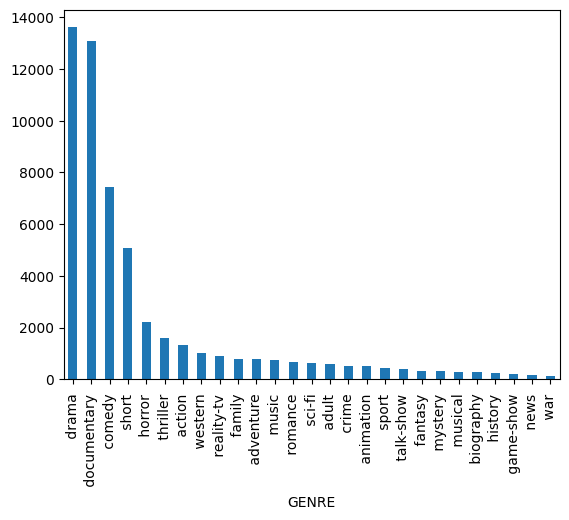

In [11]:
df['GENRE'].value_counts().plot(kind='bar')

- Lower Case
- Remove Emoji
- remove html
- remove url
- Replace certain special characters with their string equivalents
- Replace contractions
- Remove puntuations
- Romove stop-words

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lower case
    text = str(text).lower().strip()

    # Remove emoji
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove html
    pattern = re.compile('<.*?>')
    text = pattern.sub(r'', text)

    # Remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('[math]', '')

    # Contractions
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    text_decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        text_decontracted.append(word)
    text = ' '.join(text_decontracted)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = re.sub(r'\d+', '', text)

    return text

df['DESCRIPTION'] = df['DESCRIPTION'].apply(preprocess)
df.head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,listening conversation doctor parent yearold o...
2,Cupid (1997),thriller,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,bus empty student field trip museum natural hi...
4,The Secret Sin (1915),drama,help unemployed father make end meet edith twi...
5,The Unrecovered (2007),drama,film title refers unrecovered body ground zero...


# ML with Word2Vec

In [18]:
genre_mapping = {genre: idx for idx, genre in enumerate(df['GENRE'].unique())}
df['GENRE'] = df['GENRE'].map(genre_mapping)

In [19]:
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Convert descriptions to vectors
def description_to_avg_vector(description):
    words = description.split()
    word_vectors = [word2vec[word] for word in words if word in word2vec]
    if len(word_vectors) == 0:
        return np.zeros(word2vec.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Apply the function to the dataframe
df['avg_vector'] = df['DESCRIPTION'].apply(description_to_avg_vector)
df.head()

,TITLE,GENRE,DESCRIPTION,avg_vector
1,Oscar et la dame rose (2009),0,listening conversation doctor parent yearold o...,"[-0.016601562, -0.015402679, -0.00028442382, 0..."
2,Cupid (1997),1,brother sister past incestuous relationship cu...,"[-0.02789917, -0.004243978, 0.022298178, 0.022..."
3,"Young, Wild and Wonderful (1980)",2,bus empty student field trip museum natural hi...,"[0.07709503, -0.0075263977, -0.015080043, 0.08..."
4,The Secret Sin (1915),0,help unemployed father make end meet edith twi...,"[0.020593261, -0.0019986248, -0.026014328, 0.0..."
5,The Unrecovered (2007),0,film title refers unrecovered body ground zero...,"[0.08759581, 0.014757552, 0.005281844, 0.09556..."


In [20]:
X = np.array(df['avg_vector'].tolist())
y = np.array(df['GENRE'].tolist())

In [21]:
X.shape, y.shape

((54214, 300), (54214,))

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [23]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
rf_classifier.score(X_train, y_train)

0.9996541467801066

In [25]:
rf_classifier.score(X_val, y_val)

0.48538227427833625

## XGBClassifier

In [26]:
xg_classifier = XGBClassifier()
xg_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
xg_classifier.score(X_train, y_train)

0.9879412510663808

In [28]:
xg_classifier.score(X_val, y_val)

0.5480955455132344

# Deep Learning

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['DESCRIPTION'])
len(tokenizer.word_index)

136132

In [30]:
df['Token_DESCRIPTION'] = tokenizer.texts_to_sequences(df['DESCRIPTION'])
df.head(3)

,TITLE,GENRE,DESCRIPTION,avg_vector,Token_DESCRIPTION
1,Oscar et la dame rose (2009),0,listening conversation doctor parent yearold o...,"[-0.016601562, -0.015402679, -0.00028442382, 0...","[4647, 1085, 285, 128, 447, 2500, 366, 1944, 1..."
2,Cupid (1997),1,brother sister past incestuous relationship cu...,"[-0.02789917, -0.004243978, 0.022298178, 0.022...","[64, 119, 92, 12615, 85, 792, 3786, 85, 178, 1..."
3,"Young, Wild and Wonderful (1980)",2,bus empty student field trip museum natural hi...,"[0.07709503, -0.0075263977, -0.015080043, 0.08...","[1431, 1804, 115, 748, 296, 1548, 843, 100, 10..."


In [31]:
max_len = max(len(Token_DESCRIPTION) for Token_DESCRIPTION in df['Token_DESCRIPTION'])
max_len

1426

In [32]:
df['Token_DESCRIPTION'] = pad_sequences(df['Token_DESCRIPTION'], maxlen=max_len, padding='pre').tolist()

In [69]:
X = np.array(df['Token_DESCRIPTION'].tolist())
y = np.array(df['GENRE'].tolist())

## Embedding + LSTM

In [62]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(64)))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())  

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 
model.add(Dense(27, activation='softmax'))  # Assuming binary classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
import tensorflow as tf

stored_parameters1 = []

# Define your callback function to store model parameters
def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters1.append(parameters)

# Assuming 'model' is defined and compiled before this step
history = model.fit(
    X, y,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model)
        )
    ]
)

Epoch 1/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 128s 90ms/step - accuracy: 0.3301 - loss: 2.5682 - val_accuracy: 0.5015 - val_loss: 1.7779
Epoch 2/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.5643 - loss: 1.5777 - val_accuracy: 0.5036 - val_loss: 1.7315
Epoch 3/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.6527 - loss: 1.2474 - val_accuracy: 0.5031 - val_loss: 1.7583
Epoch 4/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.7330 - loss: 0.9659 - val_accuracy: 0.5028 - val_loss: 1.9679
Epoch 5/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.7887 - loss: 0.7640 - val_accuracy: 0.4840 - val_loss: 2.2006
Epoch 6/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.8316 - loss: 0.6016 - val_accuracy: 0.4838 - val_loss: 2.4242
Epoch 7/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 122s 90ms/step - accuracy: 0.8553 - loss: 0.5078 - val_accuracy: 0.4800 - val_loss: 2.7930
Epoch 8/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 121s 90ms/step - accuracy: 

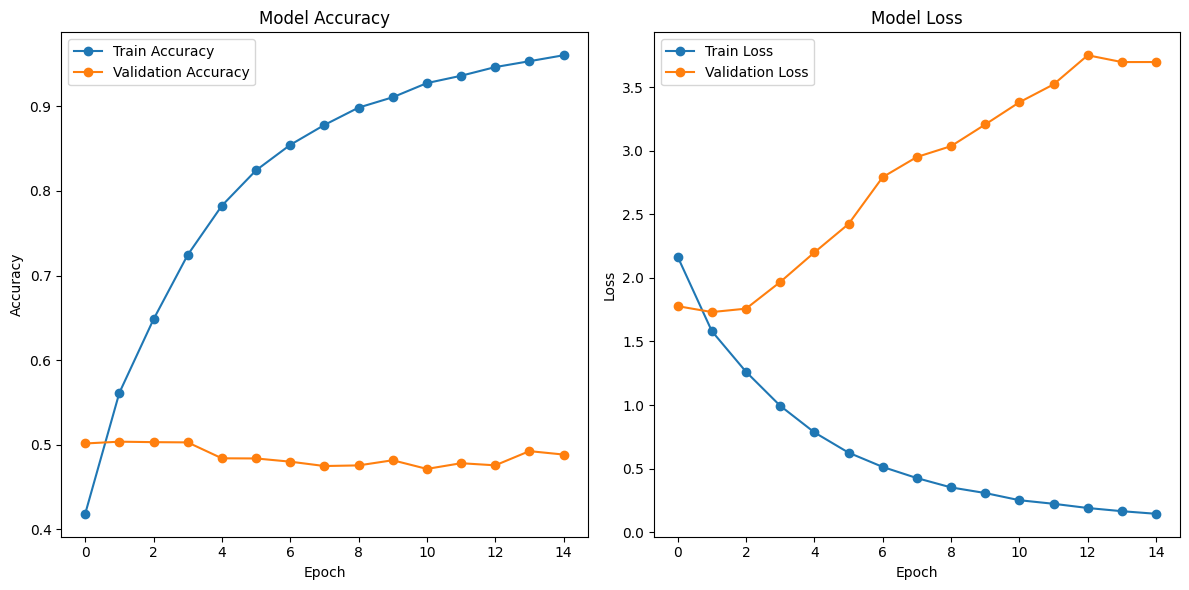

In [45]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
model.set_weights(stored_parameters1[1])

### Test model on test dataset

In [71]:
df_test = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt", sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")
df_test['DESCRIPTION'] = df_test['DESCRIPTION'].apply(preprocess)
df_test['DESCRIPTION'] = tokenizer.texts_to_sequences(df_test['DESCRIPTION'])
df_test['DESCRIPTION'] = pad_sequences(df_test['DESCRIPTION'], maxlen=max_len, padding='pre').tolist()
df_test['GENRE'] = df_test['GENRE'].map(genre_mapping)
X_test = np.array(df_test['DESCRIPTION'].tolist())
y_test = np.array(df_test['GENRE'].tolist())

model.evaluate(X_test, y_test)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 57s 33ms/step - accuracy: 0.5066 - loss: 1.7269


[1.7362481355667114, 0.5038376450538635]

## Model Using Pre-trained Word2Vec + LSTM

In [50]:
# Load pre-trained Word2Vec model
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vocab_size = len(tokenizer.word_index) + 1
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, word2vec.vector_size))
for word, index in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        embedding_matrix[index] = np.random.randn(word2vec.vector_size)

In [51]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=word2vec.vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(64)))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())  

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2)) 
model.add(BatchNormalization()) 
model.add(Dense(27, activation='softmax'))  # Assuming binary classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │    40,839,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,839,900 (155.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 40,839,900 (155.79 MB)

In [52]:
stored_parameters2 = []

# Define your callback function to store model parameters
def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters2.append(parameters)

# Assuming 'model' is defined and compiled before this step
history = model.fit(
    X, y,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model)
        )
    ]
)

Epoch 1/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 128s 92ms/step - accuracy: 0.3390 - loss: 2.5495 - val_accuracy: 0.4429 - val_loss: 1.9536
Epoch 2/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.4810 - loss: 1.8032 - val_accuracy: 0.4597 - val_loss: 1.8130
Epoch 3/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.5145 - loss: 1.6846 - val_accuracy: 0.5084 - val_loss: 1.6680
Epoch 4/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.5401 - loss: 1.5837 - val_accuracy: 0.5290 - val_loss: 1.6155
Epoch 5/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.5612 - loss: 1.5030 - val_accuracy: 0.5392 - val_loss: 1.5888
Epoch 6/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.5913 - loss: 1.4073 - val_accuracy: 0.5282 - val_loss: 1.6175
Epoch 7/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 0.6149 - loss: 1.3407 - val_accuracy: 0.5153 - val_loss: 1.6624
Epoch 8/15
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 124s 91ms/step - accuracy: 

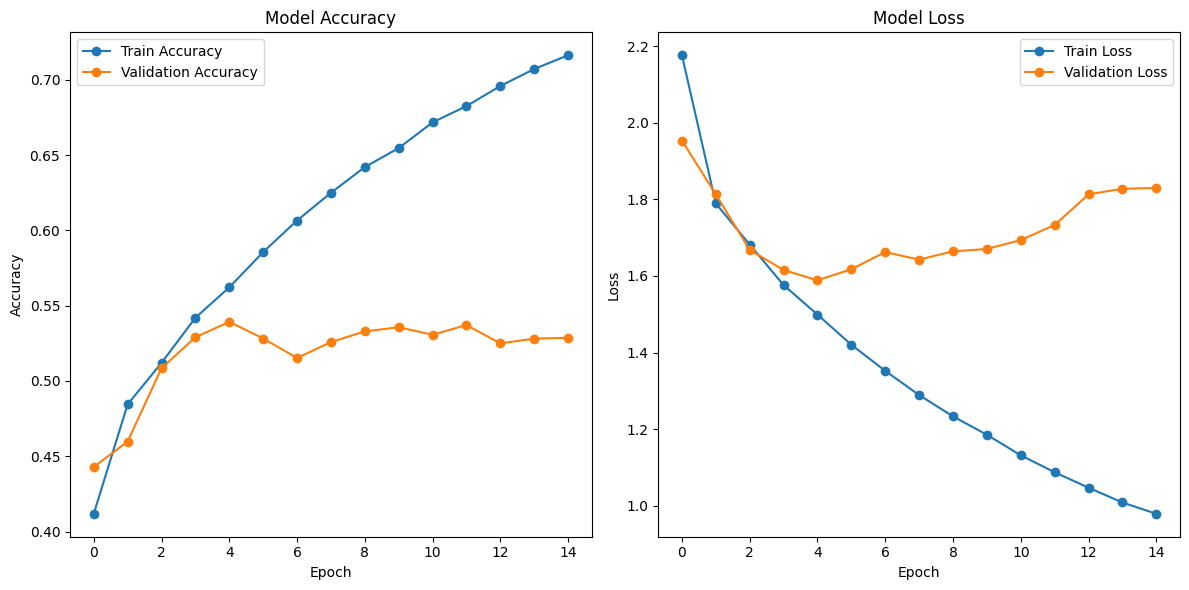

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.set_weights(stored_parameters2[4])

### Test on dataset

In [56]:
df_test = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt", sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")
df_test['DESCRIPTION'] = df_test['DESCRIPTION'].apply(preprocess)
df_test['DESCRIPTION'] = tokenizer.texts_to_sequences(df_test['DESCRIPTION'])
df_test['DESCRIPTION'] = pad_sequences(df_test['DESCRIPTION'], maxlen=1479, padding='pre').tolist()
df_test['GENRE'] = df_test['GENRE'].map(genre_mapping)
X_test = np.array(df_test['DESCRIPTION'].tolist())
y_test = np.array(df_test['GENRE'].tolist())

model.evaluate(X_test, y_test)

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.5485 - loss: 1.5383


[1.5546717643737793, 0.5438929796218872]